In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import tensorflow as tf

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import keras.backend as k
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['con1.jpg', 'sty.jpg']


In [105]:
height=512
width=512

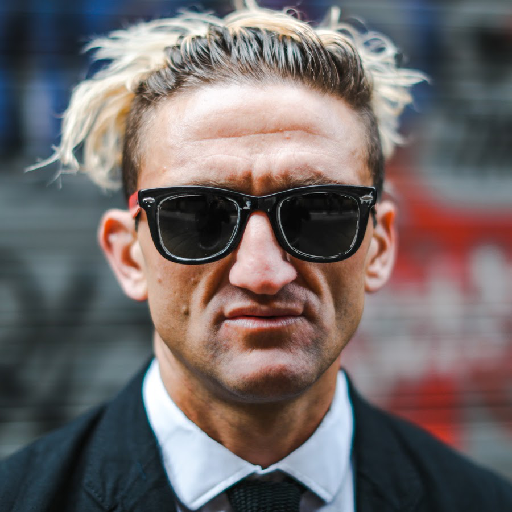

In [106]:
content_image=image.load_img('../input/con1.jpg',target_size=(height,width))
content_image

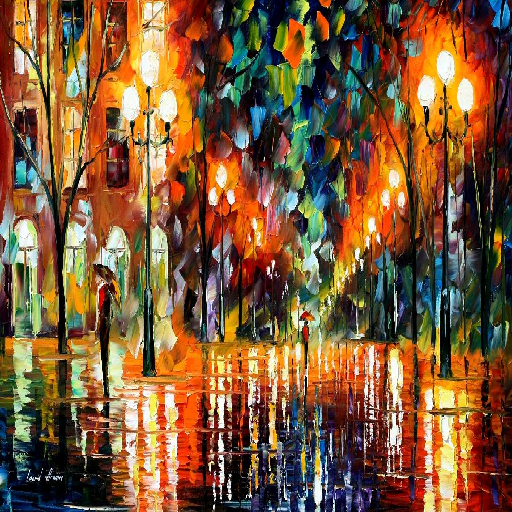

In [107]:
style_image=image.load_img('../input/sty.jpg',target_size=(height,width))
style_image

In [108]:
content_array=image.img_to_array(content_image)
style_array=image.img_to_array(style_image)
content_array=np.expand_dims(content_array,axis=0)
style_array=np.expand_dims(style_array,axis=0)
print(content_array.shape,style_array.shape)

(1, 512, 512, 3) (1, 512, 512, 3)


In [109]:
mean_vals_of_vgg=np.array([123.68, 116.779, 103.939]).reshape(1,1,1,3)
mean_vals_of_vgg.shape

(1, 1, 1, 3)

In [110]:
content_array-=mean_vals_of_vgg
style_array-=mean_vals_of_vgg
content_array=content_array[:,:,:,::-1]
style_array=style_array[:,:,:,::-1]
print(content_array.shape,style_array.shape)

(1, 512, 512, 3) (1, 512, 512, 3)


In [111]:
content_image=k.constant(content_array,dtype='float32')
style_image=k.constant(style_array,dtype='float32')
combination_image=k.placeholder((1,height,width,3),dtype='float32')

In [112]:
input_tensor=k.concatenate([content_image,style_image,combination_image],axis=0)
input_tensor

<tf.Tensor 'concat_5:0' shape=(3, 512, 512, 3) dtype=float32>

In [113]:
model=VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)

In [114]:
layers=dict([(layer.name,layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_5/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_5/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_5/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_5/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_5/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_5/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_5/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_5/Relu:0' shape=(3, 64, 64, 51

In [115]:
def content_cost(content,combination):
    cost=k.sum(k.square(content-combination))
    _,nh,nw,nc=content.get_shape().as_list()
    cost=cost/(4*nh*nw*nc)
    return cost

In [116]:
def gram_matrix(x):
    _,nh,nw,nc=x.get_shape().as_list()
    x=k.transpose(k.reshape(x,[nh*nw,nc]))
    gram=k.dot(x,k.transpose(x))
    return gram

In [117]:
def style_cost(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    cost=k.sum(k.square(S-C))
    _,nx,ny,nc=style.get_shape().as_list()
    cost=cost/(4 * (nx*ny)**2 * nc**2)
    return cost

In [118]:
content_weight=1
style_weight=5

In [119]:
x=np.random.uniform(1,255,(1,height,width,3))-128

In [120]:
style_feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
content_feature_layer='block2_conv2'

In [121]:
def compute_total_cost(layers):
    cost=0.
    feature_layer=layers[content_feature_layer]
    content_features=feature_layer[0,:,:,:]
    combination_features=feature_layer[2,:,:,:]
    ccost=content_cost(content_features,combination_features)
    scost=0.
    for layername in style_feature_layers:
        feature_layer=layers[layername]
        style_features=feature_layer[1,:,:,:]
        combination_features=feature_layer[2,:,:,:]
        scost=scost+style_cost(style_features,combination_features)
    scost=scost/len(style_feature_layers)
    cost=(content_weight*ccost) + (style_weight*scost)
    return cost

In [125]:
def train(layers):
    cost=compute_total_cost(layers)
    init=tf.GlobalVariablesInitializer()
    optimizer=tf.train.AdamOptimizer(2.).minimize(cost,var_list=[combination_image])
    with tf.Session() as sess:
        sess.run(init)
        for i in range(10):
            sess.run(optimizer)